### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ  
### Факультет искусственного интеллекта  
### Дисциплина: Инструменты обработки и визуализации данных  
## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 7
#### Студент:  Князев Арсений
#### Группа:   ЗФИбд-01-24  
#### Вариант: 4
#### Automobile Data Set 

### lib imports
___

In [1]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

### task 1
___

In [2]:
automobile = fetch_ucirepo(id=10) 

X = automobile.data.features 
y = automobile.data.targets 

In [3]:
data = pd.concat([X[["horsepower"]], X[["price"]], X[["compression-ratio"]], y], axis=1)
data.sample(5)

,horsepower,price,compression-ratio,symboling
157,70.0,7198.0,9.0,0
90,55.0,7099.0,21.9,1
24,68.0,6229.0,9.4,1
127,207.0,34028.0,9.5,3
197,114.0,16515.0,9.5,-1


### task 2
___

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   horsepower         203 non-null    float64
 1   price              201 non-null    float64
 2   compression-ratio  205 non-null    float64
 3   symboling          205 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 6.5 KB


In [5]:
data.isna().sum()

horsepower           2
price                4
compression-ratio    0
symboling            0
dtype: int64

In [6]:
data.dropna(subset=["symboling"], inplace=True)

rows_with_nan = data.drop(columns=["symboling"]).isna().any(axis=1).sum()
percent_nan_rows = rows_with_nan / len(data) * 100

print(f"Процент записей с пропущенными значениями в признаках: {percent_nan_rows:.2f}%")

if rows_with_nan > 0:
    for col in data.columns:
        if col != "symboling":
            data[col] = data[col].fillna(data[col].mean())
else:
    z_scores = np.abs(zscore(data.drop(columns=["symboling"])))
    outlier_mask = (z_scores > 3).any(axis=1)

    removed = outlier_mask.sum()
    percent_removed = removed / len(data) * 100

    if percent_removed < 5:
        z_scores = np.abs(zscore(data.drop(columns=["symboling"])))
        outlier_mask = (z_scores > 2.5).any(axis=1)
        removed = outlier_mask.sum()
        percent_removed = removed / len(data) * 100

    data.drop(index=data.index[outlier_mask], inplace=True)

    print(f"Процент удалённых точек: {percent_removed:.2f}%")

print(f"Итоговый размер набора данных: {data.shape}")

Процент записей с пропущенными значениями в признаках: 2.93%
Итоговый размер набора данных: (205, 4)


### task 3
___

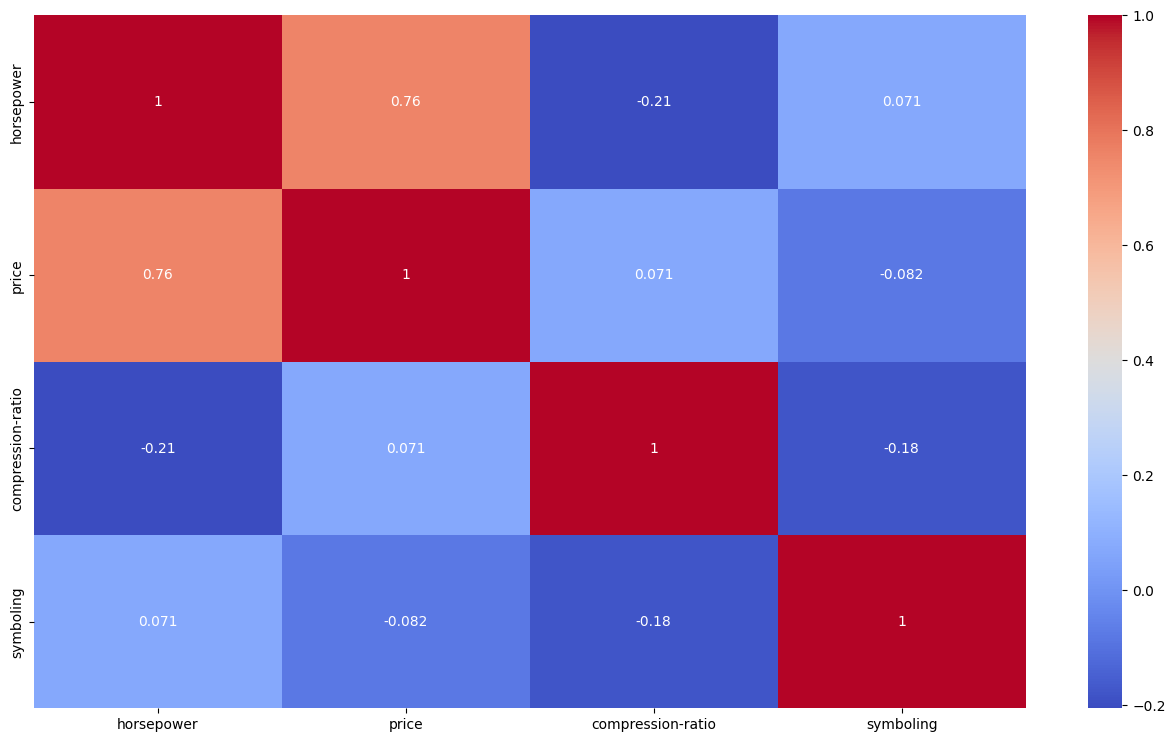

In [7]:
plt.figure(figsize=(16, 9))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.show()

In [8]:
features = data.drop(columns=["symboling"])

corr_matrix = features.corr().abs()
corr_matrix.values[[range(len(corr_matrix))]*2] = 0

x_feature, y_feature = corr_matrix.unstack().idxmax()

size_feature = [col for col in features.columns if col not in (x_feature, y_feature)][0]

fig = px.scatter(
    data,
    x=x_feature,
    y=y_feature,
    color="symboling",
    size=size_feature,
    title="Диаграмма рассеяния по признакам с наибольшей корреляцией"
)

fig.show()

### task 4
___

In [9]:
features = data.drop(columns=["symboling"])

variances = features.var()

min_var_feature = variances.idxmin()
max_var_feature = variances.idxmax()

data_sorted = data.sort_values(by=min_var_feature)

fig = px.line(
    data_sorted,
    x=min_var_feature,
    y=max_var_feature,
    color="symboling",
    title="Линейная зависимость признаков с минимальной и максимальной дисперсией"
)

fig.show()

### task 5
___

In [10]:
features = data.drop(columns=["symboling"])

variances = features.var()

min_var_feature = variances.idxmin()

fig = px.violin(
    data,
    x="symboling",
    y=min_var_feature,
    box=True,
    points="all",
    title="Скрипичная диаграмма признака с наименьшей дисперсией по классам"
)

fig.show()

In [11]:
features = data.drop(columns=["symboling"])

variances = features.var()

max_var_feature = variances.idxmax()

fig = px.box(
    data,
    x="symboling",
    y=max_var_feature,
    points="all",
    title="Диаграмма размаха признака с наибольшей дисперсией по классам"
)

fig.show()

q1 = data[max_var_feature].quantile(0.25)
q3 = data[max_var_feature].quantile(0.75)
iqr = q3 - q1

outliers = data[(data[max_var_feature] < q1 - 1.5 * iqr) | (data[max_var_feature] > q3 + 1.5 * iqr)]

print(f"Признаки с выбросами: {max_var_feature}")
print(f"Количество выбросов: {len(outliers)}")

Признаки с выбросами: price
Количество выбросов: 14


### task 7
___

In [12]:
features = data.drop(columns=["symboling"])

iqr_values = features.quantile(0.75) - features.quantile(0.25)
feature_max_iqr = iqr_values.idxmax()

fig = px.bar(
    data.groupby("symboling")[feature_max_iqr].mean().reset_index(),
    x="symboling",
    y=feature_max_iqr,
    title="Столбчатая диаграмма признака с наибольшей IQR по классам"
)

fig.show()

### task 8
____

In [13]:
first_feature = data.columns[0]
third_feature = data.columns[2]

fig = px.histogram(
    data,
    x=first_feature,
    y=third_feature,
    nbins=20,
    title=f"Гистограмма зависимости {first_feature} и {third_feature}"
)

fig.show()

### task 9
____

In [14]:
features = data.columns[:3]

fig = px.line_3d(
    data,
    x=features[0],
    y=features[1],
    z=features[2],
    color="symboling",
    title="3D линейный график для трех признаков по классам"
)

fig.show()

### task 10
___

In [15]:
features = data.columns[:3]

fig = px.scatter_3d(
    data,
    x=features[0],
    y=features[1],
    z=features[2],
    color="symboling",
    title="3D диаграмма рассеяния для трех признаков по классам"
)

fig.show()